# Quickstart Tutorial

In this tutorial, we show how to quickly set up and train an RNN-based regression model with the deep4cast package. The goal is to show you how to handle the package interface and inspect the model object after training. The example data constitutes of a monthly 26-dimensional multivariate time series.

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from deep4cast.forecasters import CNNForecaster, RNNForecaster
from pandas import read_table

%matplotlib inline

Using CNTK backend
c:\users\shirleyr\appdata\local\continuum\anaconda3\envs\deep4cast\lib\site-packages\keras\backend\cntk_backend.py:21: UserWarning: CNTK backend warning: GPU is not detected. CNTK's CPU version is not fully optimized,please run with GPU to get better performance.
  'CNTK backend warning: GPU is not detected. '


## Data preparation

Before we can fit a model we first have to load, clean, and prepare our dataset so that the model can accept it.

In [2]:
# Load the data from file
filename = 'timeseries_data.csv'
df = read_table(filename, sep=',')

In [3]:
# Set lookback window for truncated sample time series
lookback_period = 20 # i.e. 20 months
test_length = 9  # test on the last 9 months
train_length = len(df) - test_length

# Prepare train and test set
ts = df.astype('float32').values
ts_train = ts[:-test_length]
ts_test = ts[-test_length-lookback_period:]

In [4]:
def compute_mape(model, ts_eval, ts_truth):
    ts_pred = model.predict(ts_eval)
    return np.mean(np.abs((ts_pred - ts_truth) / ts_truth))*100.0

def criticize_model(model, metric=compute_mape):
    print('TRAIN \t Mean Absolute Percentage Error: {0:.1f}%'.format(metric(model, ts_train, ts[lookback_period:train_length])))
    print('TEST \t Mean Absolute Percentage Error: {0:.1f}%'.format(metric(model, ts_test, ts[train_length:])))

Before we do anything, we should probably have a quick look at a visualization of the data

Text(0.5,1,'Black: training time series; Red: testing time series')

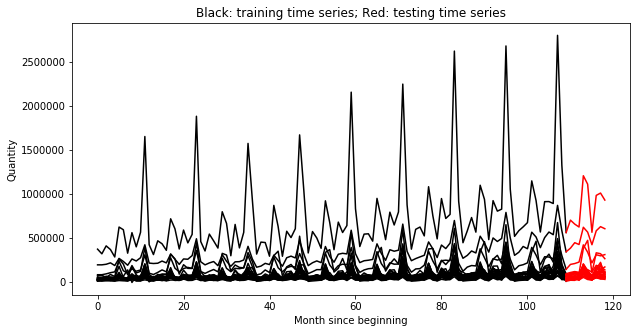

In [5]:
# Plot dataset
plt.figure(figsize=(10,5))
plt.plot(ts[:train_length], 'k')
plt.plot(range(len(ts[:train_length-1]), len(ts)), ts[train_length-1:], 'r')
plt.xlabel('Month since beginning')
plt.ylabel('Quantity')
plt.title('Black: training time series; Red: testing time series')

## Truncated Recurrent Neural Network Forecaster

Now that we have cleaned and prepared out dataset we can proceed to fit one of our built-in regression models. Here, we choose the truncated RNN, which means that the training example time series have finite length. The model is initalized with a topology object, a batch size that determines the number of training example fed into the optimizer per training batch, and a number of epochs that specifies how many trianing batches are processed.

In [6]:
# Hyper-parameters
topology = [('GRU', {'units': 128})]

# Instantiate regression model
model = RNNForecaster(topology, batch_size=8, epochs=150, learning_rate=0.01)
model.fit(ts_train, lookback_period=lookback_period)

c:\users\shirleyr\appdata\local\continuum\anaconda3\envs\deep4cast\lib\site-packages\keras\layers\core.py:642: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 128)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


Let's have a peek at what the model training and testing errors look like

In [7]:
criticize_model(model)

TRAIN 	 Mean Absolute Percentage Error: 36.7%
TEST 	 Mean Absolute Percentage Error: 25.7%


Create a model with dropout layer

Let's have a look at the history of the training loss (here mean-squared error)

Text(0,0.5,'Mean-squared training error')

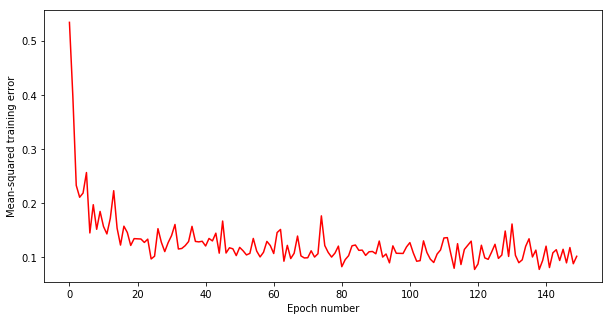

In [8]:
# Plot training error history
plt.figure(figsize=(10,5))
plt.plot(model.history.epoch, model.history.history['loss'], 'r') 
plt.xlabel('Epoch number')
plt.ylabel('Mean-squared training error')

### Predictions for truncated RNN

Let's now take the model to make some predictions and compare visually with the test data.

In [9]:
ts_pred = model.predict(ts_test)

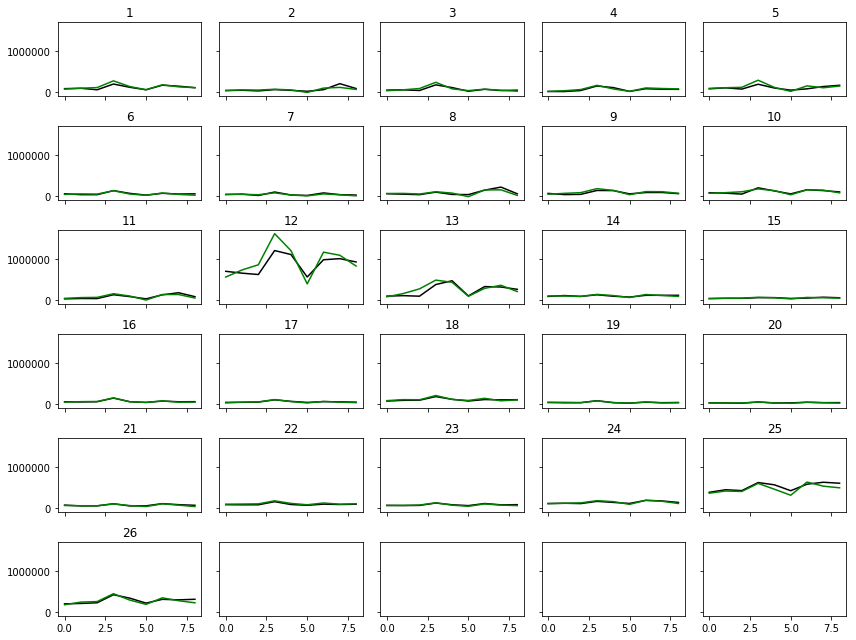

In [10]:
ncols = 5
fig, axes = plt.subplots(nrows=len(ts_pred.T)//ncols+1, ncols=ncols, sharex=True, sharey=True, figsize=(12, 9))

for ax, ya, yp, title in zip(axes.flat, ts[train_length:].T, ts_pred.T, range(1,len(ts_pred.T)+1)):
    ax.plot(ya, 'k-')
    ax.plot(yp, 'g-')
    ax.set_title(title)

plt.tight_layout()

## Temporal Convolutional Neural Network Forecaster

In the next example we choose the temporal CNN, which uses one-dimensional convolutions for modeling purposes.

In [11]:
# Hyper-parameters
topology = [
    ('Conv1D', {'filters': 64, 'kernel_size': 5, 'activation': 'elu'}),
    ('MaxPooling1D', {'pool_size': 3, 'strides': 1}),
    ('Conv1D', {'filters': 64, 'kernel_size': 3, 'activation': 'elu'}),
    ('MaxPooling1D', {'pool_size': 4, 'strides': 2}),
    ('Conv1D', {'filters': 128, 'kernel_size': 3, 'activation': 'elu'}),
    ('MaxPooling1D', {'pool_size': 3, 'strides': 1}),
    ('Flatten', {}),
    ('Dense', {'units': 128, 'activation': 'elu'})
]

# Instantiate regression model
model = CNNForecaster(topology, batch_size=8, epochs=100, learning_rate=0.1)
model.fit(ts_train, lookback_period=lookback_period)

c:\users\shirleyr\appdata\local\continuum\anaconda3\envs\deep4cast\lib\site-packages\keras\layers\core.py:642: UserWarning: `output_shape` argument not specified for layer lambda_2 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 128)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


Let's have a peek at what the model training and testing errors look like

In [12]:
criticize_model(model)

TRAIN 	 Mean Absolute Percentage Error: 22.2%
TEST 	 Mean Absolute Percentage Error: 25.6%


Let's have a look at the history of the training loss (here mean-squared error)

Text(0,0.5,'Mean-squared training error')

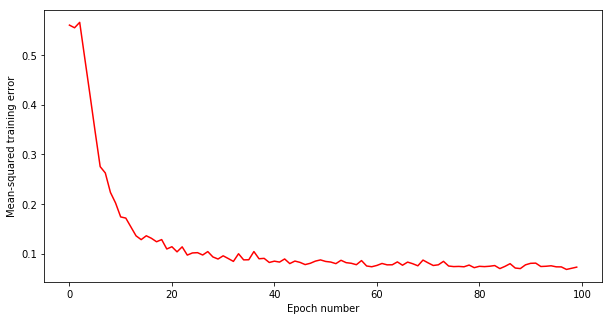

In [13]:
# Plot training error history
plt.figure(figsize=(10,5))
plt.plot(model.history.epoch, model.history.history['loss'], 'r') 
plt.xlabel('Epoch number')
plt.ylabel('Mean-squared training error')

### Predictions for temporal CNN

Let's now take the model to make some predictions and compare visually with the test data.

In [14]:
ts_pred = model.predict(ts_test)

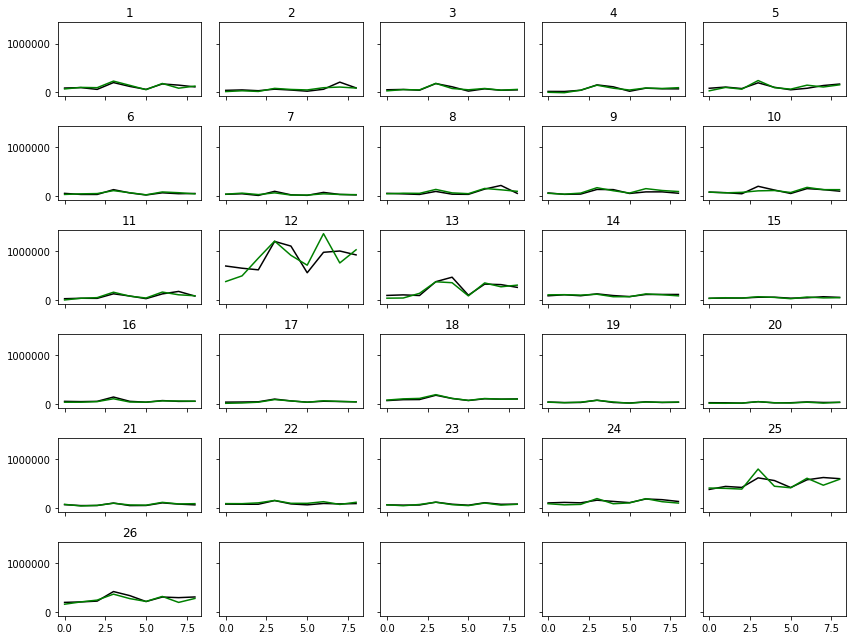

In [15]:
ncols = 5
fig, axes = plt.subplots(nrows=len(ts_pred.T)//ncols+1, ncols=ncols, sharex=True, sharey=True, figsize=(12, 9))

for ax, ya, yp, title in zip(axes.flat, ts[train_length:].T, ts_pred.T, range(1,len(ts_pred.T)+1)):
    ax.plot(ya, 'k-')
    ax.plot(yp, 'g-')
    ax.set_title(title)

plt.tight_layout()

### Add MC Dropout

Only output mean prediction

In [16]:
#ts_pred = model.predict(ts_test) 

Predict samples with default settings

In [17]:
ts_pred = model.predict_samples(ts_test)

Predict samples with specified number of samples and quantiles for confidence interval

In [18]:
#ts_pred = model.predict_samples(ts_test, n_sample=10000, quantiles=(0.05,0.95)) 

In [19]:
ts_pred_mean = ts_pred['mean_prediction']   # shape = (9, 26)
ts_pred_median = ts_pred['median_prediction']
ts_pred_upper_quantile = ts_pred['upper_quantile']
ts_pred_lower_quantile = ts_pred['lower_quantile']
ts_pred_samples = ts_pred['prediction_samples']  # shape = (1000, 9, 26)

In [20]:
ts_pred_samples.shape

(1000, 9, 26)

In [21]:
help(model.predict_samples)

Help on method predict_samples in module deep4cast.forecasters:

predict_samples(ts, n_sample=1000, quantiles=(0.025, 0.975)) method of deep4cast.forecasters.CNNForecaster instance
    Generate predictions for input time series array ts.
    Output mean, median, quantile predictions and prediction samples
     :param ts: Time series array of shape (n_steps, n_variables)
     :type ts: numpy.array
     :param n_sample: Number of prediction samples
     :type n_sample: int
     :param quantiles: Tuple of quantiles to produce corresponding confidence interval
     :type quantiles: Tuple of two floats from 0.0 to 1.0, e.g. (0.025, 0.975)



### Plot of prediction samples of test set

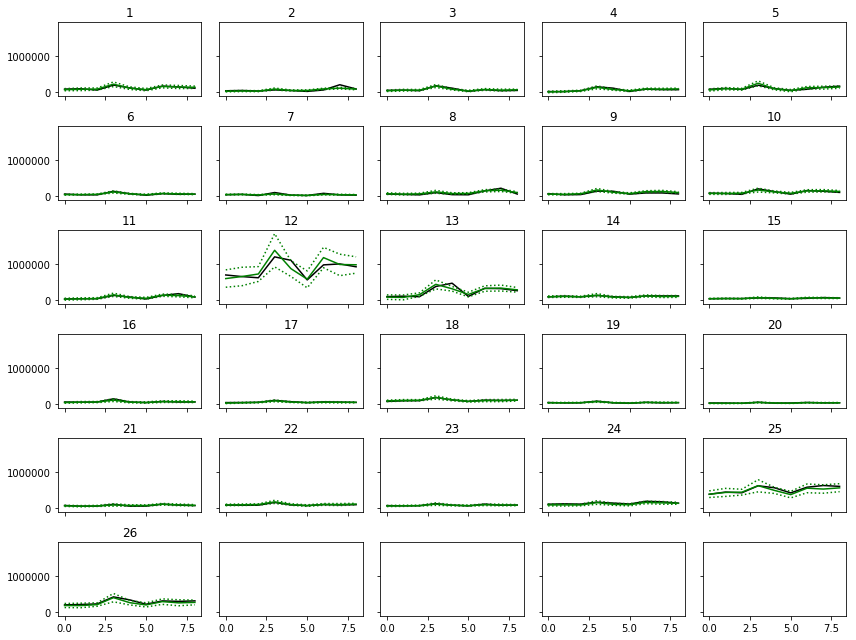

In [22]:
ncols = 5
fig, axes = plt.subplots(nrows=len(ts_pred_mean.T)//ncols+1, ncols=ncols, sharex=True, sharey=True, figsize=(12, 9))

for ax, ya, yp, yp_lower, yp_upper, title in zip(axes.flat, ts[train_length:].T, ts_pred_mean.T, 
                                        ts_pred_lower_quantile.T, ts_pred_upper_quantile.T,
                                        range(1,len(ts_pred_mean.T)+1)):
    ax.plot(ya, 'k-')
    ax.plot(yp, 'g-')
    ax.plot(yp_lower, 'g:')
    ax.plot(yp_upper, 'g:')
    ax.set_title(title)

plt.tight_layout()